In [1]:
from flax import nnx
import jax
import jax.numpy as jnp
import pennylane as qml

jax.config.update("jax_enable_x64", True)

In [2]:
N_QUBITS = 10
N_LAYERS = 2
BATCH_SIZE = 16
LEARNING_RATE = 3e-4

In [3]:
def make_circuit(dev, n_qubits, n_layers):
    @qml.qnode(dev, interface="jax-jit")
    def circuit(x, circuit_weights):
        # data encoding
        for i in range(n_qubits):
            qml.RY(x[i] * jnp.pi, wires=i)
            
        # trainable unitary
        for layer in range(n_layers):
            for idx in range(n_qubits-1):
                qml.CNOT(wires=[idx, idx+1])
            qml.CNOT(wires=[n_qubits-1, 0])
            for i in range(n_qubits):
                qml.RY(jnp.pi * jnp.tanh(circuit_weights[layer, i, 0]), wires=i)  
                qml.RZ(jnp.pi * jnp.tanh(circuit_weights[layer, i, 1]), wires=i) 
                qml.RX(jnp.pi * jnp.tanh(circuit_weights[layer, i, 2]), wires=i)  

        return [qml.expval(qml.PauliY(wires=i)) for i in range(n_qubits)]

    return jax.vmap(circuit, in_axes=(0, None)) # We return the vectorized circuit and indicate that the batch is in the first dimension.

In [4]:
class QuantumCircuit(nnx.Module):
  def __init__(self, num_qubits, num_layers, device, rngs = nnx.Rngs(42)):
    key = rngs.params()

    weight_shapes = (num_layers, num_qubits, 3)
    self.weights = nnx.Param(jax.random.uniform(key, shape=weight_shapes).astype(jnp.float32))

    self.circuit = make_circuit(device, num_qubits, num_layers)

  def __call__(self, x: jax.Array):
    return self.circuit(x, self.weights)

# Modified MNIST Tutorial from Flax Documentation

TODO: RESIZE IMAGES AND USE A SIMPLE CIRCUIT WITHH AMPLITUDE EMBEDDING

In [5]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

tf.random.set_seed(0)  # Set the random seed for reproducibility.

train_steps = 4800 * 5
eval_every = 200
batch_size = BATCH_SIZE

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # Normalize the test set.

# Create a shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from.
train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

Technical note on batch size: If the batch size doesn't divide evenly into the dataset size, the model functions will be recompiled every time the last batch is encountered as recompilation is triggered when the input shapes change.

In [6]:
from flax import nnx  # The Flax NNX API.
from functools import partial

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
    self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
    self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
    self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
    self.linear2 = nnx.Linear(256, 10, rngs=rngs)
    self.linear3 = nnx.Linear(10, 10, rngs=rngs)
    self.linear4 = nnx.Linear(10, 10, rngs=rngs)
    
    dev = qml.device('default.qubit', wires=N_QUBITS)
    self.qcirc1 = QuantumCircuit(N_QUBITS, N_LAYERS, dev)
    self.qcirc2 = QuantumCircuit(N_QUBITS, N_LAYERS, dev)

  def __call__(self, x):
    x = self.avg_pool(nnx.relu(self.conv1(x)))
    x = self.avg_pool(nnx.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)  # flatten
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    
    x = jax.nn.standardize(x)
    x = jnp.array(self.qcirc1(x)).reshape(BATCH_SIZE,-1)
    #x = jax.nn.standardize(x)
    #x = jnp.array(self.qcirc2(x)).reshape(BATCH_SIZE,-1)
    x = nnx.relu(self.linear3(x))
    x = self.linear4(x)
    return x

# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualize it.
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x11fc40360>,
    bias_init=<function zeros at 0x10fd6c0e0>,
    conv_general_dilated=<function conv_general_dilated at 0x10f5207c0>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,

In [7]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((BATCH_SIZE, 28, 28, 1)))
print(len(y))
nested_shape = [len(subtuple) for subtuple in y]
print(nested_shape)  # Output: [2, 3, 1]

16
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [8]:
import optax

learning_rate = LEARNING_RATE
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=CNN(
    conv1=Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x11fc40360>,
      bias_init=<function zeros at 0x10fd6c0e0>,
      conv_general_dilated=<function conv_general_dilated at 0x10f5207c0>
    ),
    conv2=Conv(
      kernel_shape=(3, 3, 32, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64,), dtype

In [9]:
@nnx.jit
def loss_fn(model: CNN, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

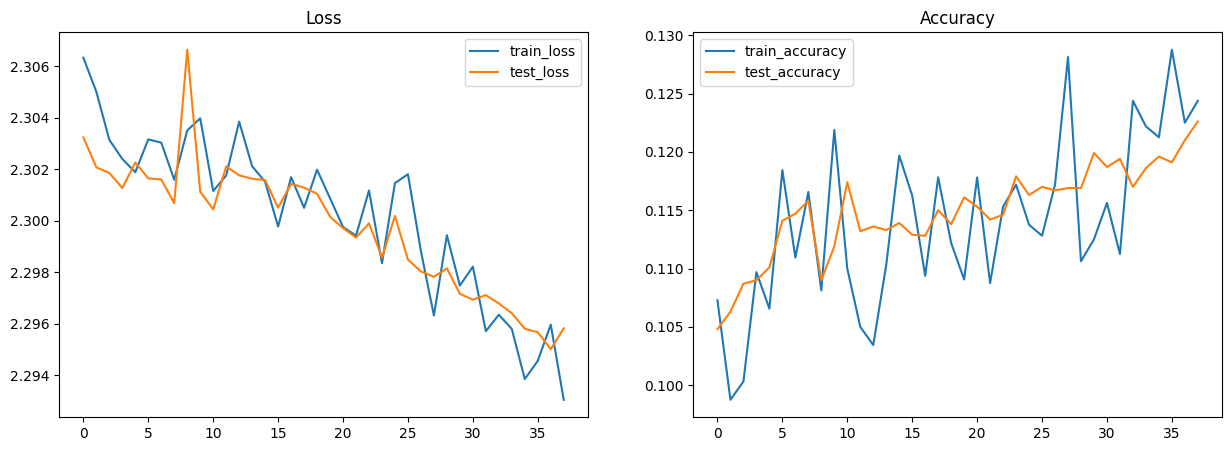

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics
  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    clear_output(wait=True)
    # Plot loss and accuracy in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    for dataset in ('train', 'test'):
      ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
      ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
    ax1.legend()
    ax2.legend()
    plt.show()

In [11]:
model.eval() # Switch to evaluation mode.

@nnx.jit
def pred_step(model: CNN, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)

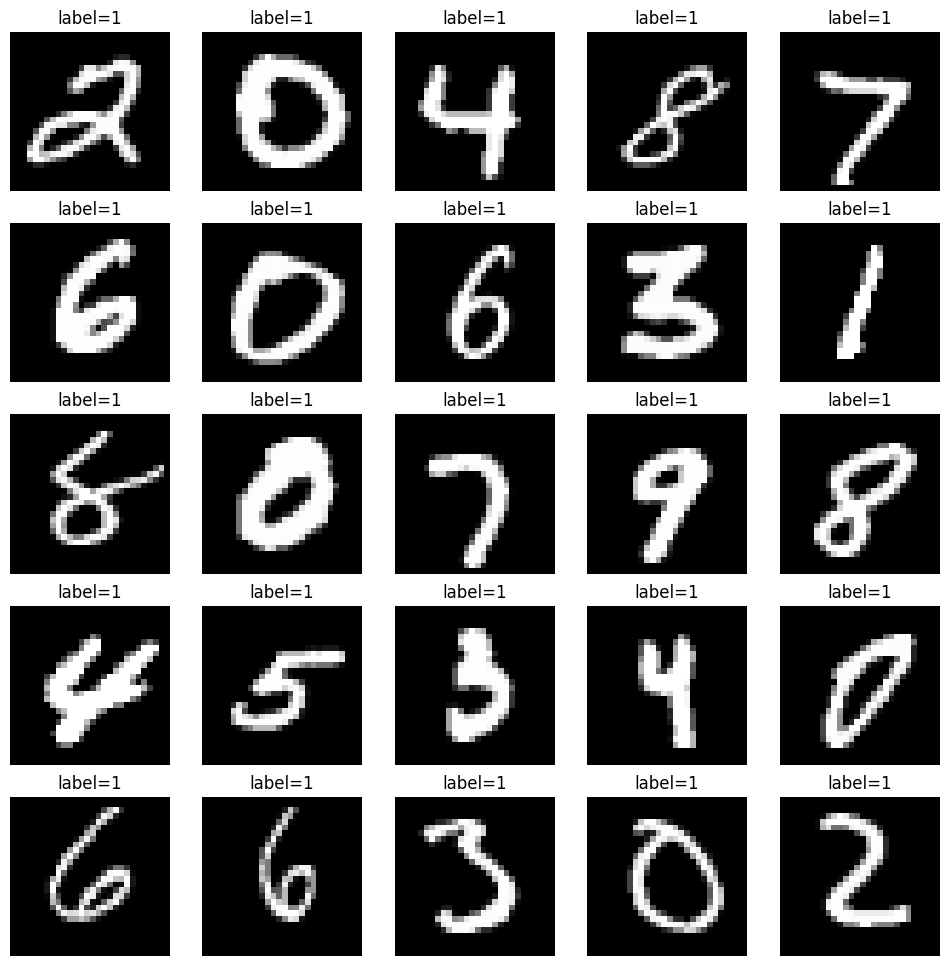

In [12]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')